TEXT DETECTION MODEL EVALUATION

[1/4] Loading trained model...
✓ Model loaded (Epoch 10, Val Loss: 0.3182)
✓ Using device: mps

[2/4] Loading test dataset...
could not parse file:  /Users/kalex/projects/ITMO/Neural_Network_Architectures/project/data/test/img/X51006619503.jpg
✓ Loaded 346 test images

[3/4] Evaluating on test dataset...
  Processed 50/346 images...
  Processed 100/346 images...
  Processed 150/346 images...
  Processed 200/346 images...
  Processed 250/346 images...
  Processed 300/346 images...

✓ Evaluation Complete!
  Total test images: 346
  Average Precision:  0.0007
  Average Recall:     0.0001
  Average F1 Score:   0.0001

[4/4] Visualizing 3 random samples...

  Sample 1: X51007846397
    Ground truth boxes: 39
    Predicted boxes: 1
    Precision: 0.000, Recall: 0.000, F1: 0.000


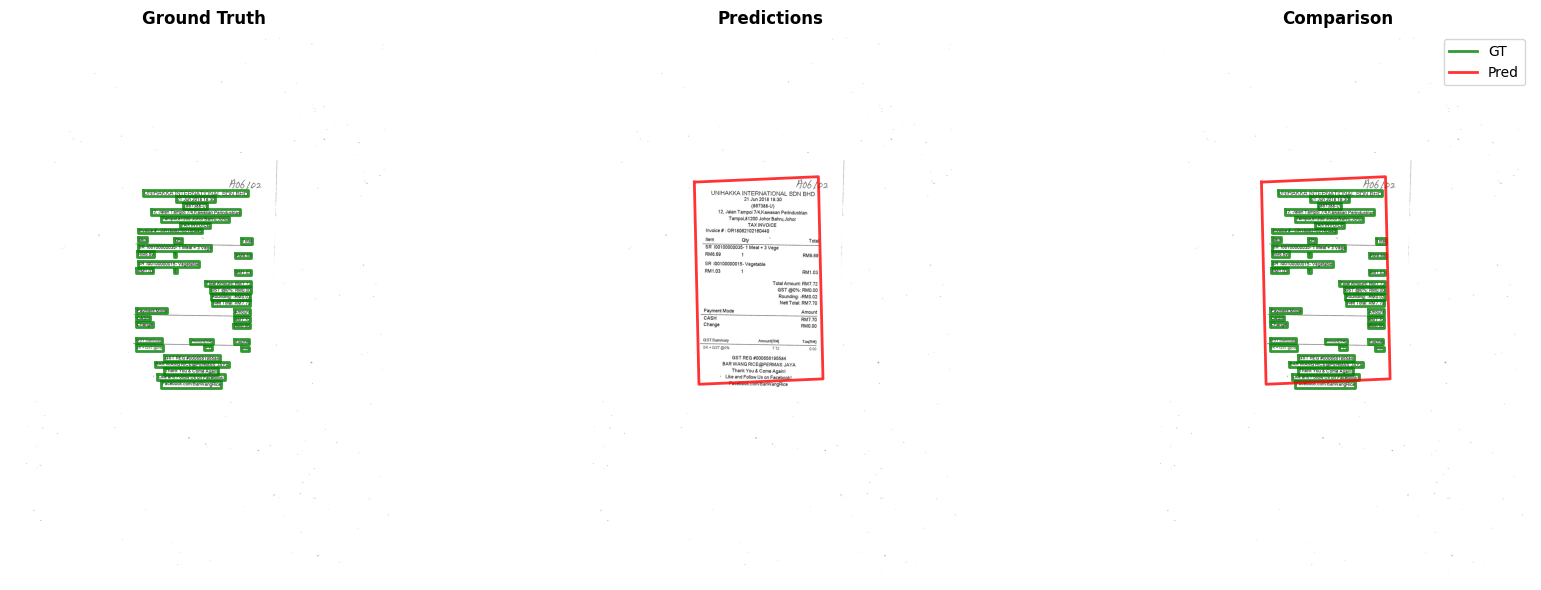


--------------------------------------------------

  Sample 2: X51005663300
    Ground truth boxes: 42
    Predicted boxes: 7
    Precision: 0.000, Recall: 0.000, F1: 0.000


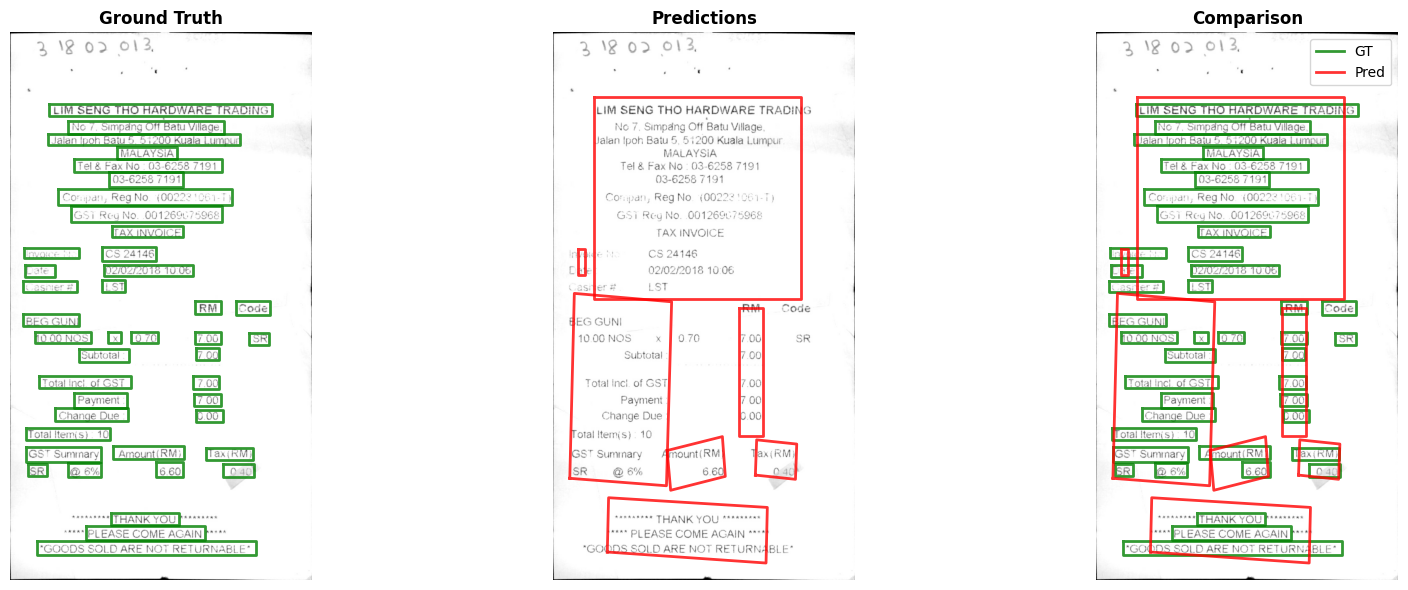


--------------------------------------------------

  Sample 3: X51005301666
    Ground truth boxes: 89
    Predicted boxes: 5
    Precision: 0.000, Recall: 0.000, F1: 0.000


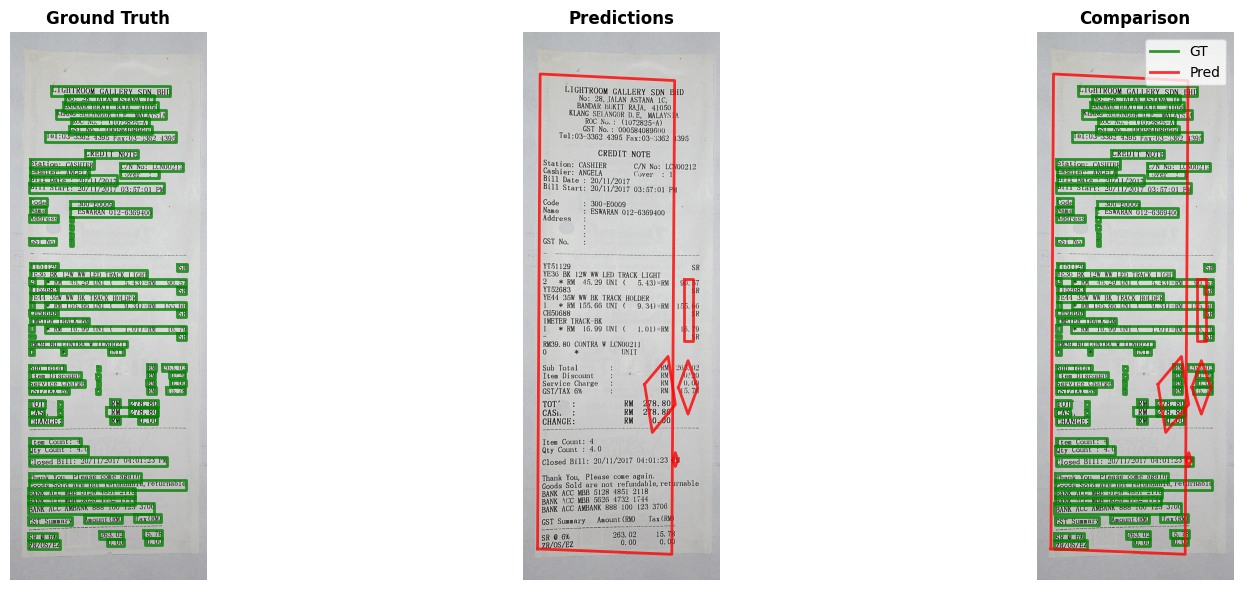


FINAL EVALUATION RESULTS
Test Dataset Size: 346 images
Overall Precision:  0.0007 (±0.0134)
Overall Recall:     0.0001 (±0.0012)
Overall F1 Score:   0.0001 (±0.0022)


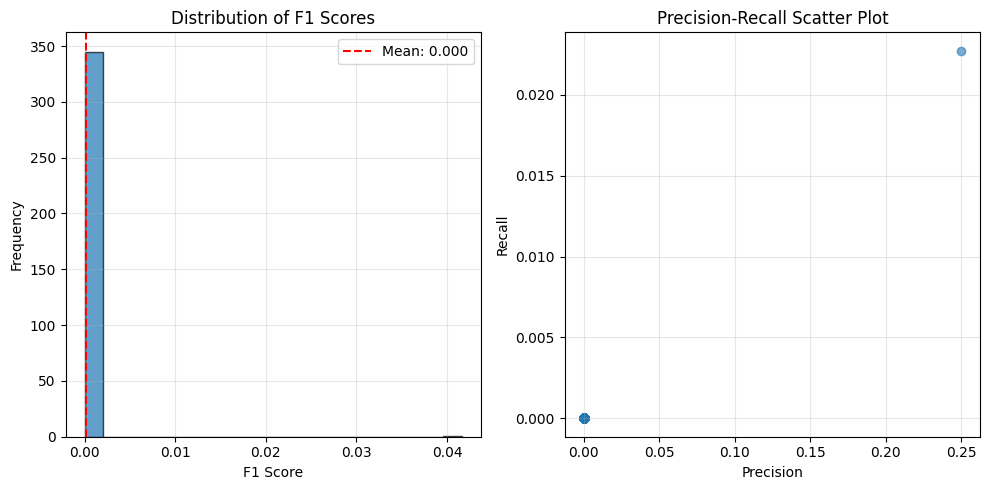


✓ Evaluation summary saved to 'test_evaluation_summary.png'

To visualize more images, run:
test_and_visualize_model(num_visualize=5)  # for 5 images


In [5]:
import torch
import customEasyOCR
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def test_and_visualize_model(model_path='best_detector_model.pth', test_dir='data/test', num_visualize=3):
    """
    Test trained model on test dataset, calculate F1 score, and visualize predictions on random images.

    Args:
        model_path: Path to saved model checkpoint
        test_dir: Path to test dataset directory
        num_visualize: Number of random images to visualize
    """
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    print("=" * 70)
    print("TEXT DETECTION MODEL EVALUATION")
    print("=" * 70)

    # ========== 1. LOAD TRAINED MODEL ==========
    print("\n[1/4] Loading trained model...")
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Create model instance
    model = customEasyOCR.TextDetectionModel(pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"✓ Model loaded (Epoch {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f})")
    print(f"✓ Using device: {device}")

    # ========== 2. LOAD TEST DATASET ==========
    print("\n[2/4] Loading test dataset...")

    test_dir = Path(test_dir)
    img_dir = test_dir / 'img'
    box_dir = test_dir / 'box'

    # Get all test images
    image_files = sorted(list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')))

    if len(image_files) == 0:
        raise ValueError(f"No images found in {img_dir}")

    # Store test data
    test_data = []
    for img_path in image_files:
        try:
            image_id = img_path.stem

            # Load image
            image = cv2.imread(str(img_path))
            if image is None:
                continue

            original_h, original_w = image.shape[:2]

            # Load ground truth boxes
            gt_boxes = []
            box_path = box_dir / f"{image_id}.txt"
            if box_path.exists():
                with open(box_path, 'r', encoding='utf-8') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) >= 8:
                            coords = list(map(int, parts[:8]))
                            # Convert to [x1, y1, x2, y2, x3, y3, x4, y4]
                            box = np.array(coords, dtype=np.float32)
                            gt_boxes.append(box)

            test_data.append({
                'image_id': image_id,
                'image_path': img_path,
                'original_size': (original_h, original_w),
                'gt_boxes': gt_boxes
            })
        except:
            print("could not parse file: ", img_path)
            continue

    print(f"✓ Loaded {len(test_data)} test images")

    # ========== 3. HELPER FUNCTIONS ==========
    def preprocess_image(image, target_size=(512, 512)):
        """Preprocess image for model"""
        resized = cv2.resize(image, (target_size[1], target_size[0]))
        tensor = torch.from_numpy(resized).permute(2, 0, 1).float() / 255.0
        return tensor.unsqueeze(0), resized

    def polygon_iou(poly1, poly2):
        """Calculate IoU between two polygons"""
        try:
            poly1 = poly1.reshape(-1, 2).astype(np.int32)
            poly2 = poly2.reshape(-1, 2).astype(np.int32)

            # Find bounding box
            max_x = max(poly1[:, 0].max(), poly2[:, 0].max()) + 2
            max_y = max(poly1[:, 1].max(), poly2[:, 1].max()) + 2

            # Create masks
            mask1 = np.zeros((max_y, max_x), dtype=np.uint8)
            mask2 = np.zeros((max_y, max_x), dtype=np.uint8)

            cv2.fillPoly(mask1, [poly1], 1)
            cv2.fillPoly(mask2, [poly2], 1)

            intersection = np.logical_and(mask1, mask2).sum()
            union = np.logical_or(mask1, mask2).sum()

            return intersection / union if union > 0 else 0
        except:
            return 0

    def extract_boxes_from_score_map(score_map, original_size, threshold=0.3, min_area=20):
        """Convert score map to bounding boxes"""
        h, w = original_size
        score_np = score_map.squeeze().cpu().numpy()

        # Threshold
        binary = (score_np > threshold).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(binary * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        boxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_area:
                continue

            # Get rotated rectangle
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.uint32(box)

            # Scale to original size
            scale_x = w / score_np.shape[1]
            scale_y = h / score_np.shape[0]
            box[:, 0] = (box[:, 0] * scale_x).astype(int)
            box[:, 1] = (box[:, 1] * scale_y).astype(int)

            boxes.append(box.flatten())

        return boxes

    def calculate_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
        """Calculate precision, recall, F1 score"""
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            return 1.0, 1.0, 1.0

        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            return 0.0, 0.0, 0.0

        # Match predictions to ground truth
        matches = []
        gt_matched = [False] * len(gt_boxes)
        pred_matched = [False] * len(pred_boxes)

        for i, gt_box in enumerate(gt_boxes):
            best_iou = 0
            best_j = -1
            for j, pred_box in enumerate(pred_boxes):
                if pred_matched[j]:
                    continue
                iou = polygon_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= iou_threshold:
                matches.append((i, best_j, best_iou))
                gt_matched[i] = True
                pred_matched[best_j] = True

        tp = len(matches)
        fp = sum([not m for m in pred_matched])
        fn = sum([not m for m in gt_matched])

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return precision, recall, f1

    def visualize_predictions(image_path, gt_boxes, pred_boxes, save_path=None):
        """Visualize ground truth and predicted boxes"""
        # Load image
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        titles = ['Ground Truth', 'Predictions', 'Comparison']
        for ax, title in zip(axes, titles):
            ax.imshow(image)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.axis('off')

        # Plot ground truth (green)
        for box in gt_boxes:
            polygon = box.reshape(4, 2)
            axes[0].plot(polygon[[0,1,2,3,0], 0], polygon[[0,1,2,3,0], 1],
                        'g-', linewidth=2, alpha=0.8)

        # Plot predictions (red)
        for box in pred_boxes:
            polygon = box.reshape(4, 2)
            axes[1].plot(polygon[[0,1,2,3,0], 0], polygon[[0,1,2,3,0], 1],
                        'r-', linewidth=2, alpha=0.8)

        # Plot both
        for box in gt_boxes:
            polygon = box.reshape(4, 2)
            axes[2].plot(polygon[[0,1,2,3,0], 0], polygon[[0,1,2,3,0], 1],
                        'g-', linewidth=2, alpha=0.8, label='GT' if box is gt_boxes[0] else "")

        for box in pred_boxes:
            polygon = box.reshape(4, 2)
            axes[2].plot(polygon[[0,1,2,3,0], 0], polygon[[0,1,2,3,0], 1],
                        'r-', linewidth=2, alpha=0.8, label='Pred' if box is pred_boxes[0] else "")

        if gt_boxes or pred_boxes:
            axes[2].legend(loc='upper right', fontsize=10)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

        plt.show()

    # ========== 4. EVALUATE ON FULL TEST SET ==========
    print("\n[3/4] Evaluating on test dataset...")

    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, sample in enumerate(test_data):
        image_path = sample['image_path']
        original_size = sample['original_size']
        gt_boxes = sample['gt_boxes']

        # Load and preprocess image
        image = cv2.imread(str(image_path))
        if image is None:
            continue

        image_tensor, _ = preprocess_image(image)
        image_tensor = image_tensor.to(device)

        # Run inference
        with torch.no_grad():
            score_map = model(image_tensor)

        # Extract predicted boxes
        pred_boxes = extract_boxes_from_score_map(score_map, original_size)

        # Calculate metrics
        precision, recall, f1 = calculate_metrics(gt_boxes, pred_boxes)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        if (i + 1) % 50 == 0:
            print(f"  Processed {i + 1}/{len(test_data)} images...")

    # Calculate overall metrics
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)

    print(f"\n✓ Evaluation Complete!")
    print(f"  Total test images: {len(test_data)}")
    print(f"  Average Precision:  {avg_precision:.4f}")
    print(f"  Average Recall:     {avg_recall:.4f}")
    print(f"  Average F1 Score:   {avg_f1:.4f}")

    # ========== 5. VISUALIZE RANDOM SAMPLES ==========
    print(f"\n[4/4] Visualizing {num_visualize} random samples...")

    # Select random samples
    if len(test_data) < num_visualize:
        num_visualize = len(test_data)

    random_indices = random.sample(range(len(test_data)), num_visualize)

    for i, idx in enumerate(random_indices):
        sample = test_data[idx]
        image_id = sample['image_id']
        image_path = sample['image_path']
        original_size = sample['original_size']
        gt_boxes = sample['gt_boxes']

        print(f"\n  Sample {i+1}: {image_id}")
        print(f"    Ground truth boxes: {len(gt_boxes)}")

        # Load and preprocess
        image = cv2.imread(str(image_path))
        image_tensor, _ = preprocess_image(image)
        image_tensor = image_tensor.to(device)

        # Inference
        with torch.no_grad():
            score_map = model(image_tensor)

        # Get predictions
        pred_boxes = extract_boxes_from_score_map(score_map, original_size)

        # Calculate metrics for this sample
        precision, recall, f1 = calculate_metrics(gt_boxes, pred_boxes)

        print(f"    Predicted boxes: {len(pred_boxes)}")
        print(f"    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

        # Visualize
        save_path = f"test_result_{i+1}_{image_id}.png"
        visualize_predictions(image_path, gt_boxes, pred_boxes, save_path)

        if i < num_visualize - 1:
            print("\n" + "-" * 50)

    # ========== 6. FINAL SUMMARY ==========
    print("\n" + "=" * 70)
    print("FINAL EVALUATION RESULTS")
    print("=" * 70)
    print(f"Test Dataset Size: {len(test_data)} images")
    print(f"Overall Precision:  {avg_precision:.4f} (±{np.std(all_precisions):.4f})")
    print(f"Overall Recall:     {avg_recall:.4f} (±{np.std(all_recalls):.4f})")
    print(f"Overall F1 Score:   {avg_f1:.4f} (±{np.std(all_f1s):.4f})")

    # Plot distribution of F1 scores
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(all_f1s, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(avg_f1, color='red', linestyle='--', label=f'Mean: {avg_f1:.3f}')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of F1 Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(all_precisions, all_recalls, alpha=0.6)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('test_evaluation_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Evaluation summary saved to 'test_evaluation_summary.png'")
    print("=" * 70)

    return {
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'all_precisions': all_precisions,
        'all_recalls': all_recalls,
        'all_f1s': all_f1s
    }

# ========== USAGE ==========
if __name__ == "__main__":
    # Simply call the function
    results = test_and_visualize_model(
        model_path='/Users/kalex/projects/ITMO/Neural_Network_Architectures/project/Task1/RectEasyOCR/best_detector_model.pth',
        test_dir='/Users/kalex/projects/ITMO/Neural_Network_Architectures/project/data/test',
        num_visualize=3
    )

    print("\nTo visualize more images, run:")
    print("test_and_visualize_model(num_visualize=5)  # for 5 images")